In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


In [2]:
# Training parameters

do_training = False

run2_input = False

omtf_input = False

model_name = 'model'

epochs = 300

batch_size = 2048

tile = 4

# ______________________________________________________________________________
if run2_input:
  from nn_encode_run3 import nlayers, nvariables
  from nn_data_run3 import (muon_data_split, pileup_data_split, mix_training_inputs)
  
  infile_muon = infile_muon_run3
  infile_pileup = infile_pileup_run3
  
  model_name = 'model_run3'
  
  epochs = 300
  
  tile = 6

# ______________________________________________________________________________
if omtf_input:
  from nn_encode_omtf import nlayers, nvariables
  from nn_data_omtf import (muon_data_split, pileup_data_split, mix_training_inputs)
  
  infile_muon = infile_muon_omtf
  infile_pileup = infile_pileup_omtf
  
  model_name = 'model_omtf'
  
  epochs = 450
  
  tile = 10

### Import data

In [3]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3
if run2_input:
  test_size = 0.304
if omtf_input:
  test_size = 0.311

x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
    muon_data_split(infile_muon, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=test_size)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.26.npz ...
[INFO    ] Loaded the variables with shape (3338550, 179)
[INFO    ] Loaded the parameters with shape (3338550, 6)
[INFO    ] Loaded the encoded variables with shape (3338550, 36)
[INFO    ] Loaded the encoded parameters with shape (3338550,)
[INFO    ] Loaded # of training and testing events: (2336985, 1001565)


In [4]:
# Import pileup data
# 'x' is the array of input variables, 'aux' is pileup info (jobid, ievt, highest_part_pt, highest_track_pt)

test_job = 159

pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test, pu_x_road_train, pu_x_road_test = \
    pileup_data_split(infile_pileup, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_job=test_job)

# Add output nodes for pileup data
if add_noise:
  labels = np.zeros((pu_x_train.shape[0],), dtype=np.float32)
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), labels]
  labels = np.zeros((pu_x_test.shape[0],), dtype=np.float32)
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), labels]

[INFO    ] Loading pileup data from ../test7/histos_tbd.26.npz ...
[INFO    ] Loaded the variables with shape (1708040, 179)
[INFO    ] Loaded the auxiliary PU info with shape (1708040, 4)
[INFO    ] Loaded the encoded variables with shape (1708040, 36)
[INFO    ] Loaded the encoded auxiliary PU info with shape (1708040, 4)
[INFO    ] Loaded # of training and testing events: (1406345, 301695)


### Training

In [5]:
# Training with Batch Normalization
# 'model' is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator
# BN is applied right after the input layers

if do_training:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, 
                                                   discr_pt_cut=discr_pt_cut, tile=tile)
    #x_train_new, y_train_new = mix_training_inputs_2(x_train, y_train, highpt_x_train, highpt_y_train, pu_x_train, pu_y_train, pu_aux_train, 
    #                                                 discr_pt_cut=discr_pt_cut, tile=tile)
  else:
    raise Exception('add_noise must be set to True')
  
  model = create_model_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, 
                           l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                           nodes1=30, nodes2=25, nodes3=20)
  logger.info('Training model with l1_reg: {0} l2_reg: {0}'.format(l1_reg, l2_reg))
  
  # Start training
  history = train_model(model, x_train_new, y_train_new,
                        model_name=model_name, epochs=epochs, batch_size=batch_size,
                        callbacks=[lr_decay,], validation_split=0.1, verbose=1)
  
  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['regr_loss'][-1], history.history['discr_loss'][-1], 
             history.history['val_loss'][-1], history.history['val_regr_loss'][-1], history.history['val_discr_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - regr_loss: {2} - discr_loss: {3} - val_loss: {4} - val_regr_loss: {5} - val_discr_loss: {6}'.format(*metrics))

In [6]:
# Validation

if do_training:
  # Loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.ylim(2,7)
  plt.show()

if False:
  plt.figure()
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.figure()
  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Regression Results

In [7]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, separation_score, find_efficiency_errors, \
                         np_printoptions)

from sklearn.metrics import (mean_squared_error, mean_absolute_error, median_absolute_error, \
                             roc_curve, roc_auc_score, log_loss)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

In [8]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
#K.set_learning_phase(0)
loaded_model = load_my_model(name=model_name+".json", weights_name=model_name+'_weights.h5')
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//8

# Prepare y_test_true, y_test_pred
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_pred = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
if isinstance(y_test_pred, list):
  y_test_pred = y_test_pred[0]
y_test_pred = y_test_pred.reshape(-1)
y_test_pred /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_pred.shape, y_test_pred

[INFO    ] # of entries: 125195, mean: -1.934505e-04, std: 3.515972e-02, mse: 1.404296e-03, mae: 2.395380e-02, mad: 2.299599e-02
[INFO    ] gaus fit (a, mu, sig): 1.081959e+04, 6.450199e-05, 2.015449e-02


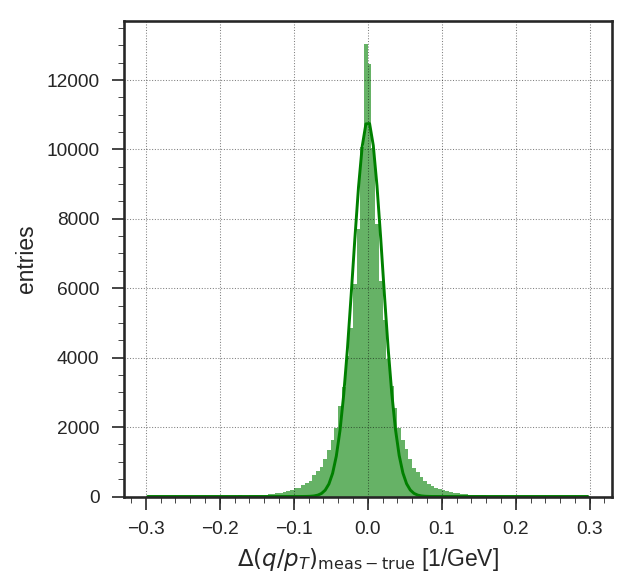

In [9]:
# Plot Delta(q/pT)
plt.figure()
yy = y_test_pred - y_test_true
mse, mae, mad = mean_squared_error(y_test_true, y_test_pred), mean_absolute_error(y_test_true, y_test_pred), median_absolute_error(y_test_true, y_test_pred)/0.6745  # (y_true, y_pred)
hist, edges, _ = plt.hist(yy, bins=120, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 125195, mean: 1.346282e-01, std: 1.188649e-01, mse: 1.181230e+02, mae: 2.604646e-01, mad: 1.320303e-01
[INFO    ] gaus fit (a, mu, sig): 9.466723e+03, -1.029769e-02, 1.194221e-01


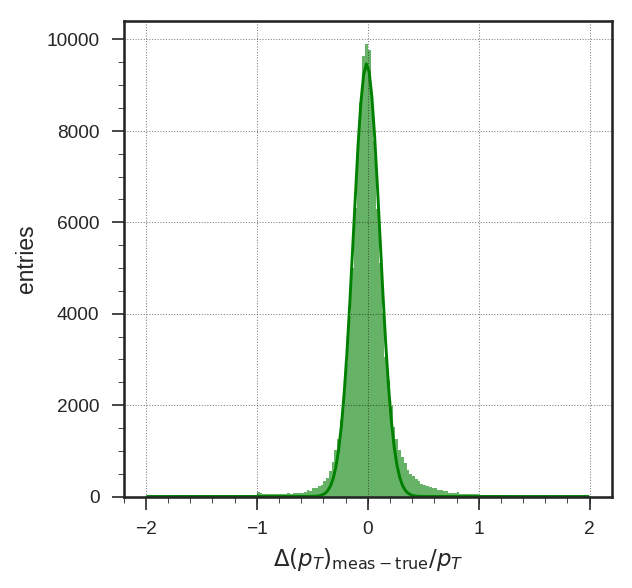

In [10]:
# Plot Delta(q/pT) / pT
plt.figure()
yy = (np.abs(1.0/y_test_pred) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
mse, mae, mad = mean_squared_error(np.abs(y_test_true/y_test_true), np.abs(y_test_true/y_test_pred)), mean_absolute_error(np.abs(y_test_true/y_test_true), np.abs(y_test_true/y_test_pred)), median_absolute_error(np.abs(y_test_true/y_test_true), np.abs(y_test_true/y_test_pred))/0.6745  # (y_true, y_pred)
hist, edges, _ = plt.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


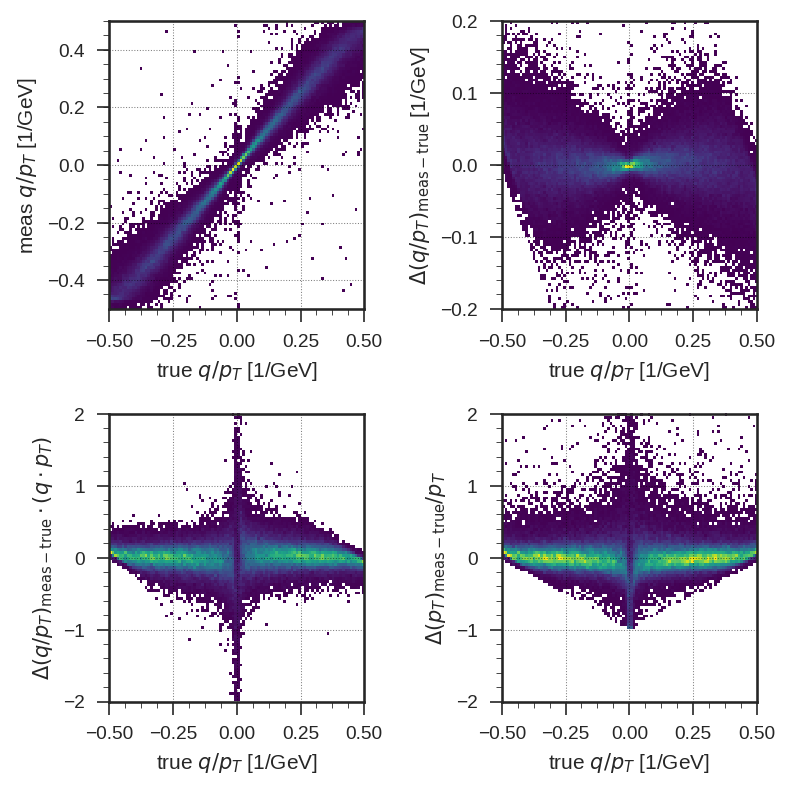

In [11]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

axs[0,0].hist2d(y_test_true, y_test_pred, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_pred - y_test_true
axs[0,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_pred - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(1.0/y_test_pred) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
axs[1,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [12]:
# Make better resolution plot
# resolution defined as delta pT over pT (no charge), binned in 1/pT (also no charge)
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_pred) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print i, len(xx_i), zdata.sum(), hightail
  
  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]
  
  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage

[INFO    ] gaus fit (a, mu, sig): 8.919547e+01, -4.845841e-02, 1.503287e-01
[INFO    ] gaus fit (a, mu, sig): 6.991998e+01, -4.893615e-02, 1.796045e-01
[INFO    ] gaus fit (a, mu, sig): 6.866039e+01, -4.514435e-02, 1.898833e-01


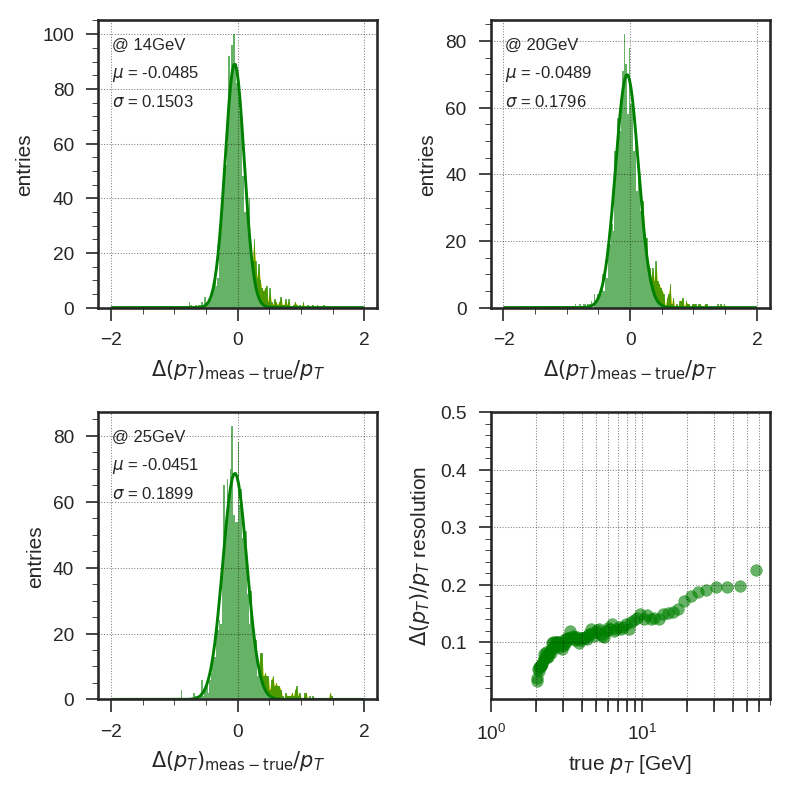

In [13]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = (hist - ydata)
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
  ax.set_ylabel(r'entries', fontsize=10)

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
yy = yy_25GeV
pt = 25
doit()

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,70)
ax.set_ylim(0,0.5+eps)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,70,10)))
ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

[INFO    ] high tail prob: 8.547134e-02, 7.907553e-02, 7.556656e-02


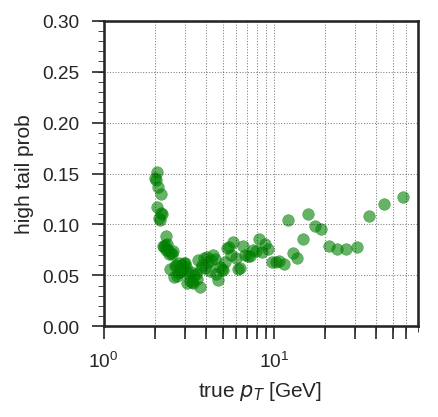

In [14]:
# Estimate high tail that is underestimated by gaus fit
logger.info('high tail prob: {0:e}, {1:e}, {2:e}'.format(zzz[ind_14GeV],zzz[ind_20GeV],zzz[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, zzz, color='g', alpha=0.6)
ax.set_xlim(1,70)
ax.set_ylim(0,0.3+eps)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'high tail prob', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,70,10)))
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

[INFO    ] coverage # of sigmas: 1.532906e+00, 1.479211e+00, 1.369944e+00


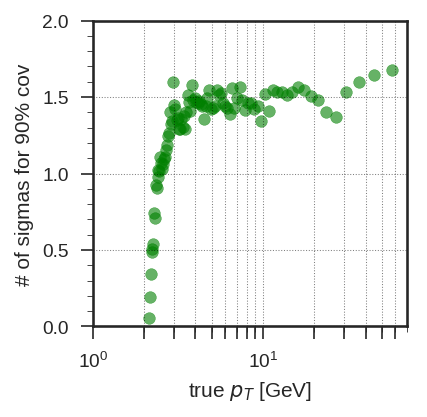

In [15]:
# Estimate coverage, find required number of sigmas for 90% coverage
# If truly gaussian, the required number of sigmas is 1.28155
#import scipy.special
#print scipy.special.erfinv(0.80) * np.sqrt(2)
logger.info('coverage # of sigmas: {0:e}, {1:e}, {2:e}'.format(ttt[ind_14GeV],ttt[ind_20GeV],ttt[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, ttt, color='g', alpha=0.6)
ax.set_xlim(1,70)
ax.set_ylim(0,2+eps)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'# of sigmas for 90% cov', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,70,10)))
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

### Classification Results

In [16]:
# Prepare y_test_true, y_test_pred (again)
y_test_true = [y_test[0][:nentries_test].copy(), y_test[1][:nentries_test].copy()]
y_test_pred = loaded_model.predict(x_test[:nentries_test], batch_size=4096)

y_test_sel = (y_test_true[1] != mask_value)  # skip low pT muons
y_test_true[0] /= reg_pt_scale
y_test_pred[0] /= reg_pt_scale
#print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
#print y_test_pred[0].shape, y_test_pred[0], y_test_pred[1].shape, y_test_pred[1]

# Prepare pu_y_test_true, pu_y_test_pred
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)  # veto PU events with high-pT tracks
pu_y_test_true = [pu_y_test[0].copy(), pu_y_test[1].copy()]
pu_y_test_pred = loaded_model.predict(pu_x_test, batch_size=4096)
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_pred[0] /= reg_pt_scale
#print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
#print pu_y_test_pred[0].shape, pu_y_test_pred[0], pu_y_test_pred[1].shape, pu_y_test_pred[1]

In [17]:
def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any((valid[0], valid[1], valid[5], valid[9], valid[11])):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any((valid[2], valid[6], valid[10])):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any((valid[3], valid[7])):  # ME3, RE3
    mode |= (1<<1)
  if np.any((valid[4], valid[8])):  # ME4, RE4
    mode |= (1<<0)
  return mode

[INFO    ] # of entries: (299666, 35466), ll: 7.667887e-02, ss: 9.798257e-01


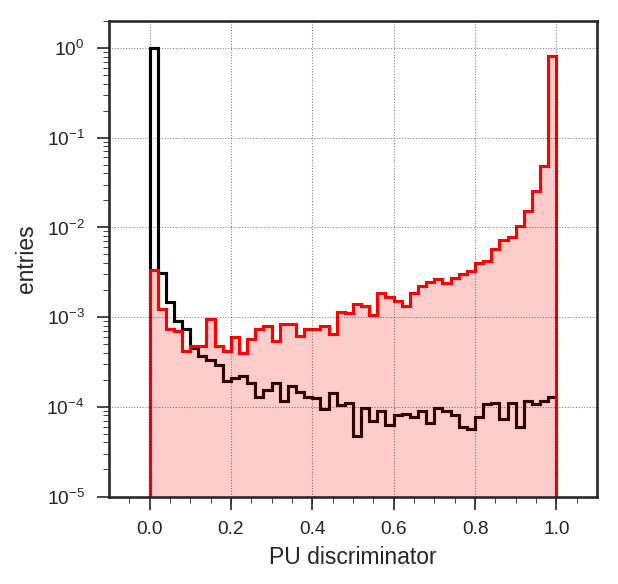

In [18]:
# Plot discriminator
plt.figure()
xx = pu_y_test_pred[1][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_pred[1][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))

ll = log_loss(np.zeros_like(xx), xx, labels=(0,1)) + log_loss(np.ones_like(yy), yy, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(xx, yy)
logger.info('# of entries: {0}, ll: {1:e}, ss: {2:e}'.format((len(xx), len(yy)), ll, ss))

plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black', lw=1.5)
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='stepfilled', color='red', alpha=0.2)
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red', lw=1.5)
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
plt.xlim(-0.1, 1.1)
plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

In [19]:
# Plot ROC
xx = np.concatenate((y_test_true[1][y_test_sel], pu_y_test_true[1][pu_y_test_sel]))
yy = np.concatenate((y_test_pred[1][y_test_sel], pu_y_test_pred[1][pu_y_test_sel]))
zz = np.concatenate((y_test_pred[0][y_test_sel], pu_y_test_pred[0][pu_y_test_sel]))
xx = xx[:, np.newaxis]
print xx.shape, yy.shape, zz.shape

(335132, 1) (335132, 1) (335132, 1)


[INFO    ] auc: 0.980328261914
[INFO    ] thr: [0.9647, 0.9491, 0.9188, 0.8693, 0.8486, 0.8230, 0.7767, 0.7065, 0.2269]
[INFO    ] tpr: [0.9019, 0.9251, 0.9501, 0.9701, 0.9752, 0.9801, 0.9854, 0.9900, 0.9991]
[INFO    ] fpr: [0.0577, 0.0795, 0.1215, 0.1652, 0.1906, 0.2115, 0.2360, 0.2657, 0.4799]
[INFO    ] auc: 0.992322040843
[INFO    ] thr: [0.9926, 0.9892, 0.9792, 0.9641, 0.9641, 0.9500, 0.9286, 0.8748, 0.4896]
[INFO    ] tpr: [0.9016, 0.9268, 0.9575, 0.9750, 0.9750, 0.9811, 0.9861, 0.9914, 0.9991]
[INFO    ] fpr: [0.0231, 0.0283, 0.0386, 0.0463, 0.0463, 0.0566, 0.0720, 0.1003, 0.2082]


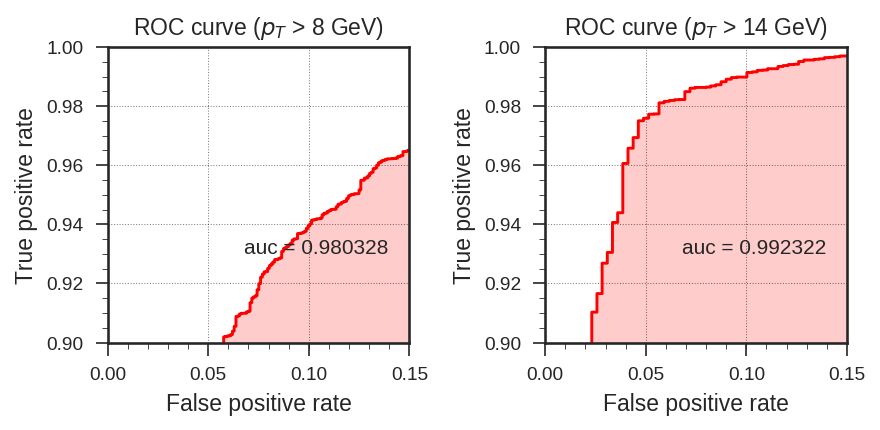

In [20]:
# Plot ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]

# pT > 8 GeV, corresponding to 10 GeV trigger threshold
zzz = np.abs(1.0/zz) > discr_pt_cut
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[0].plot(fpr, tpr, color='r')
axs[0].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[0].set_title(r'ROC curve ($p_{T}$ > 8 GeV)')
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[0].set_xlim(0.0,0.15)
axs[0].set_ylim(0.9,1.0)

# pT > 14 GeV, corresponding to 20 GeV trigger threshold
zzz = np.abs(1.0/zz) > discr_pt_cut_high
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{T}$ > 14 GeV)')
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.15)
axs[1].set_ylim(0.9,1.0)

plt.show()

### Efficiency & Rates 

In [21]:
# Build track producer

from six.moves import range, zip, map, filter

#pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

pt_bins = (-0.49376795, -0.38895044, -0.288812, -0.19121648, -0.0810074, 0.0810074, 0.19121648, 0.288812, 0.38895044, 0.49376795)

#pt_bins = (-0.49349323, -0.38373062, -0.28128058, -0.18467896, -0.07760702, 0.07760702, 0.18467896, 0.28128058, 0.38373062, 0.49349323)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - np.abs(ipt - best_ipt)

theta_to_eta_lut = [
  2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
  2.309, 2.284, 2.259, 2.236, 2.212, 2.190, 2.167, 2.145, 2.124, 2.103,
  2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.950, 1.932, 1.915,
  1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.800, 1.785, 1.770, 1.755,
  1.740, 1.726, 1.711, 1.697, 1.683, 1.670, 1.656, 1.642, 1.629, 1.616,
  1.603, 1.590, 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
  1.482, 1.470, 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
  1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
  1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
  1.180, 1.171, 1.162, 1.154, 1.145, 1.136, 1.128, 1.119, 1.111, 1.103,
  1.094, 1.086, 1.078, 1.070, 1.062, 1.054, 1.046, 1.038, 1.030, 1.022,
  1.014, 1.007, 0.999, 0.991, 0.984, 0.976, 0.969, 0.961, 0.954, 0.946,
  0.939, 0.932, 0.924, 0.917, 0.910, 0.903, 0.896, 0.888, 0.881, 0.874,
  0.867, 0.860, 0.853, 0.847, 0.840, 0.833, 0.826, 0.819, 0.813, 0.806,
  0.799, 0.793, 0.786, 0.779, 0.773, 0.766, 0.760, 0.753, 0.747, 0.741
]
theta_to_eta_lut = np.asarray(theta_to_eta_lut)

def theta_to_eta_f(theta):
  eta = theta_to_eta_lut[theta.astype(np.int32)]
  return eta

In [22]:
class TrackProducer(object):
  def __init__(self, omtf_input=False, run2_input=False):
    self.omtf_input = omtf_input
    self.run2_input = run2_input

    self.discr_pt_cut = 8.
    self.discr_pt_cut_high = 14.

    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.8195,  1.5651,  1.6147,  1.8573,  2.2176,  2.6521,  3.1392,  3.6731,
                  4.2603,  4.9059,  5.5810,  6.2768,  6.9787,  7.6670,  8.3289,  8.9703,
                  9.6027, 10.2288, 10.8525, 11.4874, 12.1370, 12.8016, 13.4806, 14.1740,
                 14.8822, 15.5927, 16.3161, 17.0803, 17.8854, 18.6790, 19.4369, 20.1713,
                 20.9279, 21.6733, 22.3966, 23.0878, 23.7421, 24.3612, 24.9927, 25.6638,
                 26.4131, 27.2467, 28.1087, 28.9682, 29.8129, 30.6270, 31.4258, 32.2671,
                 33.1881, 34.2942, 35.4266, 36.4711, 37.5020, 38.4437, 39.2068, 39.8264,
                 40.3814, 40.9442, 41.5449, 42.1736, 42.7892, 43.4046, 44.0388, 44.7361,
                 45.5805, 46.6375, 47.7231, 48.6278, 49.3952, 50.1290, 50.8860, 51.6510,
                 52.4043, 53.1551, 53.9053, 54.6554, 55.4054, 56.1554, 56.9053, 57.6552,
                 58.4051, 59.1550, 59.9048, 60.6547, 61.4045, 62.1544, 62.9042, 63.6540,
                 64.4039, 65.1537, 65.9036, 66.6534, 67.4032, 68.1531, 68.9029, 69.6527,
                 70.4026, 71.1524, 71.9022, 72.6521, 73.4019, 74.1517, 74.9016, 75.6514,
                 76.4012, 77.1511, 77.9009, 78.6507, 79.4006, 80.1504, 80.9002, 81.6501,
                 82.3999, 83.1497, 83.8996, 84.6494, 85.3992, 86.1491, 86.8989, 87.6488]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)

  def get_trigger_pt(self, x, y_pred):
    xml_pt = np.abs(1.0/y_pred)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-5)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return binx.astype(np.int32)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if binx == self.s_nbins-1:  # check boundary
      binx -= 1

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, ndof, mode, strg, zone, theta_median, y_pred, y_discr):
    ipt1 = strg
    ipt2 = find_pt_bin(y_pred)
    quality1 = find_emtf_road_quality(ipt1)
    quality2 = find_emtf_road_quality(ipt2)

    #mode_ok = (mode in (11,13,14,15))
    mode_ok = True

    strg_ok = quality2 <= (quality1+1)

    trigger = (y_discr < 0.)  # False

    if mode_ok:
      if self.omtf_input:
        if np.abs(1.0/y_pred) > self.discr_pt_cut_high:  # >14 GeV
          trigger = (y_discr > 0.6043) # 98.0% coverage
        elif np.abs(1.0/y_pred) > self.discr_pt_cut:  # 8-14 GeV
          trigger = (y_discr > 0.2905) # 98.0% coverage
        else:
          trigger = (y_discr >= 0.) and strg_ok
      elif self.run2_input:
        if np.abs(1.0/y_pred) > self.discr_pt_cut_high:  # >14 GeV
          trigger = (y_discr > 0.8557) # 97.0% coverage
        elif np.abs(1.0/y_pred) > self.discr_pt_cut:  # 8-14 GeV
          trigger = (y_discr > 0.6640) # 97.0% coverage
        else:
          trigger = (y_discr >= 0.) and strg_ok
      else:
        if np.abs(1.0/y_pred) > self.discr_pt_cut_high:  # >14 GeV
          trigger = (y_discr > 0.9286) # 98.5% coverage
        elif np.abs(1.0/y_pred) > self.discr_pt_cut:  # 8-14 GeV
          trigger = (y_discr > 0.7767) # 98.5% coverage
        else:
          trigger = (y_discr >= 0.) and strg_ok
    return trigger

  def run(self, slim_roads, variables, predictions, x_mask_vars, x_road_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(x_mask_vars))
    assert(len(slim_roads) == len(x_road_vars))

    tracks = []

    for myroad, x, y, x_mask, x_road in zip(slim_roads, variables, predictions, x_mask_vars, x_road_vars):
      assert(len(x.shape) == 1)
      assert(y.shape == (1,2))
      assert(x_mask.shape == (nlayers,))
      assert(x_road.shape == (3,))

      y_pred = np.asscalar(y[0,0])
      y_discr = np.asscalar(y[0,1])
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)
      strg, zone, theta_median = x_road

      passed = self.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
      xml_pt = np.abs(1.0/y_pred)
      pt = self.get_trigger_pt(x, y_pred)

      if passed:
        trk_q = np.sign(y_pred)
        trk_emtf_phi = myroad.id[4]
        trk_emtf_theta = theta_median
        trk = Track(myroad.id, myroad.hits, mode, zone, xml_pt, pt, trk_q, trk_emtf_phi, trk_emtf_theta, ndof, y_discr)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer(omtf_input=omtf_input, run2_input=run2_input)

In [23]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, x_road, y_pred, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, x_road_test, y_test_pred[0], y_test_pred[1], y_test_true[0])):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(x, y_pred)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20:
    print ievt, ndof, float(y_discr), float(pt_true), float(xml_pt), float(pt), passed
  
eff_data = np.asarray(eff_data)

0 5 9.25686836126e-05 2.45673870196 2.1621992588 2.3585511559 [False]
1 8 0.000164485842106 2.80159877938 2.88332438469 3.02553461556 [ True]
2 8 0.992945849895 5.13737005836 6.58766269684 7.78304787807 [False]
3 6 0.875121712685 10.6345911025 8.41107749939 10.1174512447 [ True]
4 5 3.74087976525e-05 2.6324087124 2.69625115395 2.84328787417 [ True]
5 4 4.37760136265e-05 2.46723492584 2.61631512642 2.76541419616 [ True]
6 7 0.997326493263 25.260077242 27.7996273041 40.1589863075 [ True]
7 7 3.65378618881e-05 2.65450854014 2.68691420555 2.83419181905 [ True]
8 7 0.00018750129675 2.285297392 2.5817553997 2.73174611039 [ True]
9 6 0.809399545193 6.95431669236 7.91806602478 9.49906990814 [ True]
10 8 0.991515398026 4.77910994389 5.78987884521 6.68373192291 [False]
11 9 0.999861359596 16.4169330651 14.1947402954 18.1944917969 [ True]
12 7 0.328531980515 5.24319582062 5.45112466812 6.20878508816 [False]
13 5 0.99160939455 24.5036347126 25.303188324 36.0599604088 [ True]
14 5 0.000211617225432

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


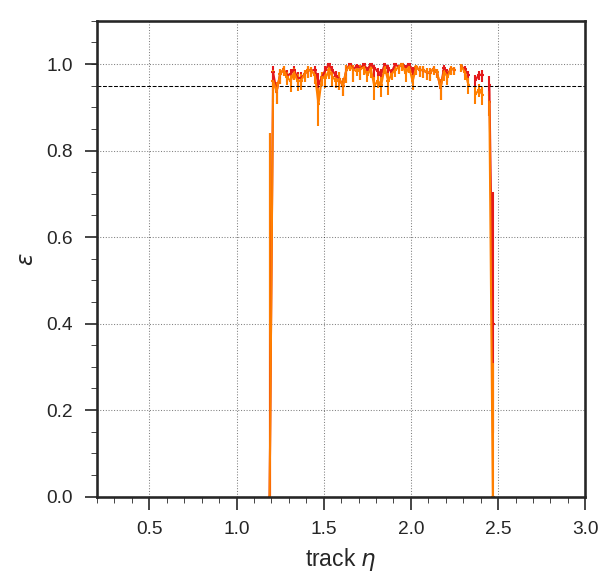

In [24]:
# Efficiency vs eta
plt.figure()

nbinsx = 90
xlow = 0.7
xup = 2.5

eff_data_theta = eff_data[:, 5]  # index 5 is theta_median
eff_data_eta = np.apply_along_axis(theta_to_eta_f, 0, eff_data_theta)

pt_thresh = 20
gen_pt_thresh = 30
gen_passed = eff_data[:, 1] > gen_pt_thresh  # index 1 is pt_true
denom_hist, edges = np.histogram(eff_data_eta[gen_passed], bins=nbinsx, range=(xlow,xup))  

# Efficiency for (L1 pT > 20) only
color = my_palette[1]
passed = gen_passed & (eff_data[:, 3] > pt_thresh)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

# Efficiency for (L1 pT > 20 only && passed)
color = my_palette[3]
passed = gen_passed & (eff_data[:, 3] > pt_thresh) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)
  
plt.plot([xlow-0.5,xup+0.5], [0.95,0.95], ls='dashed', lw=0.5, color='black')
plt.xlim(xlow-0.5,xup+0.5)
plt.ylim(0,1.1)
plt.xlabel(r'track $\eta$')
plt.ylabel(r'$\epsilon$')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


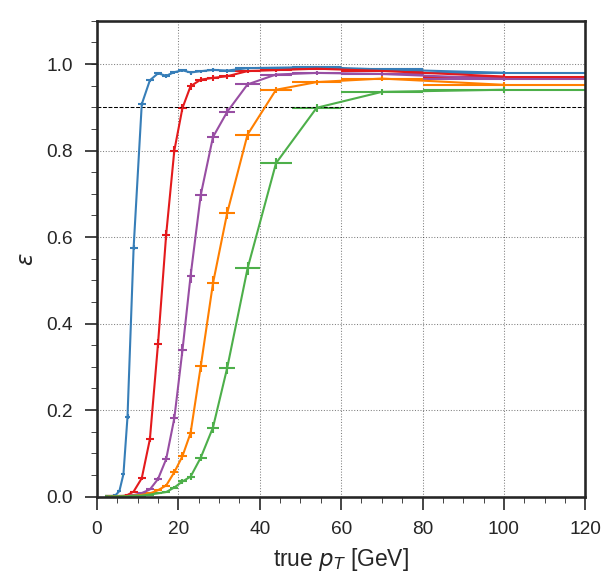

In [25]:
# Efficiency vs pT
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

pt_list = (10., 20., 30., 40., 50.)

plt.figure()

if omtf_input:
  gen_passed = (0.8 <= eff_data_eta) & (eff_data_eta <= 1.24)
else:
  gen_passed = (1.24 <= eff_data_eta) & (eff_data_eta <= 2.4)

denom_hist, edges = np.histogram(eff_data[:, 1][gen_passed], bins=eff_pt_bins)  # index 1 is pt_true

for pt, color in zip(pt_list, my_palette):
  passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is pt_true
  eff_hist = np.true_divide(num_hist, denom_hist)
  
  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  #print pt, ydata
  
  plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [26]:
# Find out pT scale factor

nbinsx = 120
xedges = np.linspace(0, 60, num=nbinsx+1)  # 0.5GeV step size

xxx = np.zeros((5,nbinsx), dtype=np.float32)

for j in xrange(5):  # j = zone0-1, zone2-4, zone5, zone6, all zones
  if j == 0:
    eff_data_tmp = np.logical_or(eff_data[:,0]==0, eff_data[:,0]==1)
  elif j == 1:
    eff_data_tmp = np.logical_or(eff_data[:,0]==2, eff_data[:,0]==3, eff_data[:,0]==4)
  elif j == 2:
    eff_data_tmp = (eff_data[:,0]==5)
  elif j == 3:
    eff_data_tmp = (eff_data[:,0]==6)
  elif j == 4:
    eff_data_tmp = (eff_data[:,0]>=0)
  
  xx = eff_data[:,1][eff_data_tmp]  # pt_true
  yy = eff_data[:,2][eff_data_tmp]  # xml_pt
  zz = eff_data[:,4][eff_data_tmp]  # discr_passed
  
  ind = np.digitize(xx, xedges[1:])
  
  for i in xrange(nbinsx):  # i = pT in 0.5GeV step
    if xedges[i] <= 4:  # ignore below 4 GeV
      xxx[j,i] = xedges[i]
      continue
    
    if xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 36:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size
    xx_i = xx[(i <= ind) & (ind <= i+step)]
    yy_i = yy[(i <= ind) & (ind <= i+step)]
    zz_i = zz[(i <= ind) & (ind <= i+step)]
    coverage = 90  
    coverage += 1.0 # inefficiency due to fiducial cuts
    #coverage += 1.5 # inefficiency due to fiducial cuts
    #pct = np.percentile(yy_i, 100-coverage, overwrite_input=True)
    
    yz_i = np.where(zz_i==0, 0, yy_i)  # muons who passed
    if len(yz_i) < 100:  # not enough stats
      continue
    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    
    xxx[j,i] = pct
    
    # Debug
    if j == 4 and 14 <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)

#print np.array2string(xxx, separator=', ', precision=4, floatmode='fixed')

14.0 2.10057288351
14.5 1.90063354451
15.0 2.12919523638
15.5 2.26474033581
16.0 2.23752151463
16.5 1.87385740402
17.0 2.1359223301
17.5 1.85471406491
18.0 1.82018753447
18.5 1.82752712736
19.0 1.80505415162
19.5 1.51228733459
20.0 1.44073346431
20.5 1.57998683344
21.0 1.74216027875
21.5 1.86706497386
22.0 1.86046511628
22.5 1.94647201946
23.0 1.84372256365
23.5 1.95903829029
24.0 1.7825311943
24.5 1.46396396396
25.0 1.40845070423
25.5 1.1911852293
26.0 1.21876904327
26.5 1.20405576679
27.0 1.27345844504
27.5 1.44329896907
28.0 1.47575544624
28.5 1.54298310066
29.0 1.2927756654
29.5 1.15207373272
30.0 1.12089671737


[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

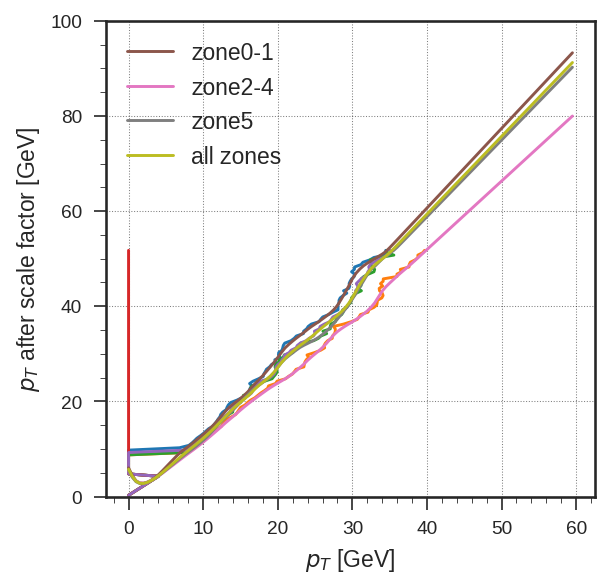

In [27]:
plt.figure()

xdata = (xedges[1:] + xedges[:-1])/2
plt.plot(xxx[0,:-16], xdata[:-16])
plt.plot(xxx[1,:-16], xdata[:-16])
plt.plot(xxx[2,:-16], xdata[:-16])
plt.plot(xxx[3,:-16], xdata[:-16])
plt.plot(xxx[4,:-16], xdata[:-16])
plt.xlabel(r'$p_{T}$ [GeV]')
plt.ylabel(r'$p_{T}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf4 = Rbf(xxx[4,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')

xdata = xedges[:-1]
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)
ydata4 = rbf4(xdata)

if not omtf_input:
  line0, = plt.plot(xdata, ydata0)
  line1, = plt.plot(xdata, ydata1)
  line2, = plt.plot(xdata, ydata2)
  #line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line0, line1, line2, line4), ('zone0-1', 'zone2-4', 'zone5', 'all zones'), loc='upper left')
else:
  #line0, = plt.plot(xdata, ydata0)
  #line1, = plt.plot(xdata, ydata1)
  #line2, = plt.plot(xdata, ydata2)
  line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line3, line4), ('zone6', 'all zones'), loc='upper left')

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata4, separator=', ', precision=4, floatmode='fixed')

def monotonically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
assert(monotonically_increasing(ydata4[6:]))

plt.ylim(0,100)
plt.show()

In [28]:
# Rates
rates_jobid_offset = 159 - 30
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for ievt, (x, x_mask, x_road, y_pred, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_x_road_test, pu_y_test_pred[0], pu_y_test_pred[1], pu_aux_test)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  #xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(x, y_pred)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  
  trk_eta = theta_to_eta_f(theta_median)
  if omtf_input:
    trk_eta_ok = (0.8 <= trk_eta <= 1.24)
  else:
    trk_eta_ok = (1.24 <= trk_eta <= 2.4)
  
  if jobid < (rates_njobs-1):
    if passed and trk_eta_ok:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and trk_eta_ok:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_jobs = (31,50,56,60,)
  if jobid in test_jobs and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt), 
    print "{0} {1} {2}".format(ndof, pt, y_discr)
    if pt > 100.:  # why?
      with np_printoptions(precision=3, suppress=True):
        if omtf_input:
          nlayers1 = 9
        else:
          nlayers1 = 12
        for lay in xrange(nlayers1):
          tmp = np.arange(2) * nlayers1 + lay
          print "....", lay, x[tmp]

  31 2826 19.5646 27.5000 7 [23.7692168] [0.99604297]
  31 2937 11.6057 18.0000 7 [39.48895786] [0.9841397]
  31 4581  1.5373     nan 5 [20.65253776] [0.99084455]
  50 6191 19.5523 14.5000 6 [20.964814] [0.95932275]
  56  851  1.6143 18.5000 6 [20.75654631] [0.9624693]
  56 7108 12.3301 24.0000 7 [21.31468942] [0.9994199]
  56 7815 12.3604 22.5000 6 [22.45835195] [0.93374246]
  60 7637  2.2862 18.0000 7 [20.26127295] [0.94980246]


[INFO    ] nevents: 258400/498400


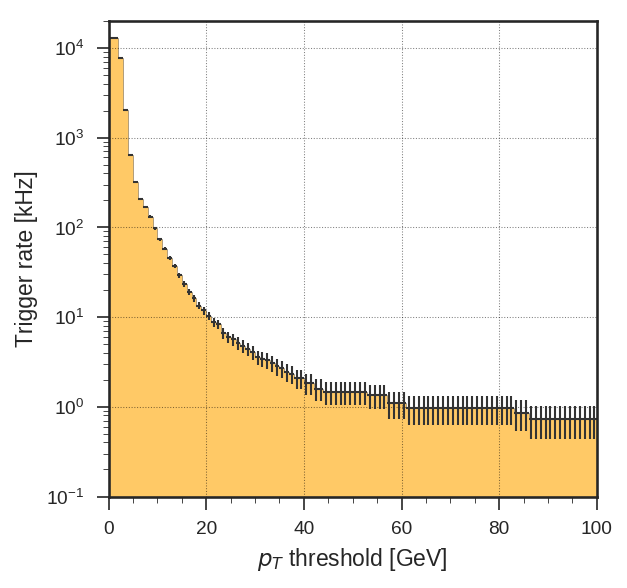

[INFO    ] Rates at 18/19/20/21/22/25 GeV: 13.4429740384, 11.854258962, 10.3877527192, 8.79903764278, 8.31020221859, 5.62160734087


[1.2901e+04, 1.2901e+04, 7.8039e+03, 2.0411e+03, 6.3891e+02, 3.1994e+02,
 2.0690e+02, 1.6669e+02, 1.3150e+02, 9.7034e+01, 7.3936e+01, 5.8049e+01,
 4.5095e+01, 3.6907e+01, 2.9330e+01, 2.3220e+01, 1.9187e+01, 1.6132e+01,
 1.3443e+01, 1.1854e+01, 1.0388e+01, 8.7990e+00, 8.3102e+00, 6.5993e+00,
 5.9882e+00, 5.6216e+00, 5.1328e+00, 4.7661e+00, 4.3995e+00, 4.0329e+00,
 3.5441e+00, 3.4218e+00, 3.2996e+00, 3.0552e+00, 2.8108e+00, 2.6886e+00,
 2.4442e+00, 2.3220e+00, 2.0776e+00, 2.0776e+00, 1.8331e+00, 1.8331e+00,
 1.5887e+00, 1.5887e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.3443e+00,
 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00,
 1.0999e+00, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.

In [29]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.show()

logger.info("Rates at 18/19/20/21/22/25 GeV: {0}, {1}, {2}, {3}, {4}, {5}".format(hist[18], hist[19], hist[20], hist[21], hist[22], hist[25]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

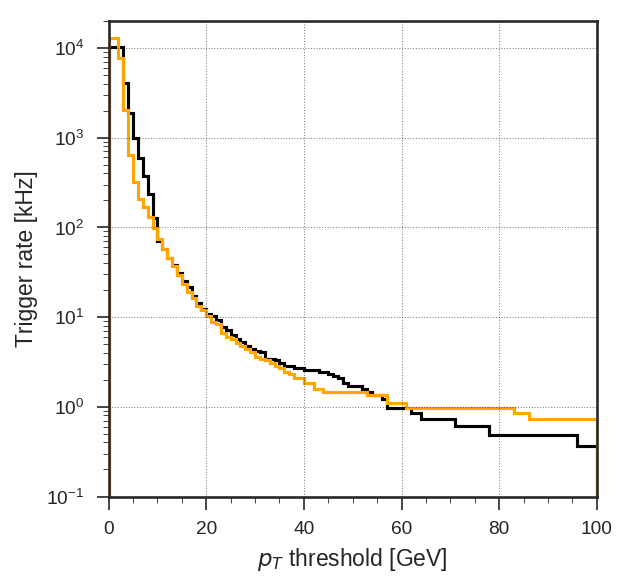

In [30]:
# Old rates
old_hist = [1.0308e+04, 1.0308e+04, 1.0308e+04, 4.0897e+03, 1.8846e+03, 9.9760e+02,
 5.9589e+02, 3.7664e+02, 2.3440e+02, 1.2795e+02, 7.0148e+01, 5.7560e+01,
 4.5217e+01, 3.8007e+01, 3.0797e+01, 2.5542e+01, 2.1509e+01, 1.7354e+01,
 1.4421e+01, 1.2343e+01, 1.0877e+01, 1.0143e+01, 9.2878e+00, 7.8213e+00,
 7.0881e+00, 6.2326e+00, 5.6216e+00, 5.2550e+00, 4.7661e+00, 4.3995e+00,
 4.1551e+00, 4.0329e+00, 3.4218e+00, 3.4218e+00, 3.2996e+00, 3.0552e+00,
 2.8108e+00, 2.8108e+00, 2.6886e+00, 2.6886e+00, 2.5664e+00, 2.5664e+00,
 2.5664e+00, 2.4442e+00, 2.4442e+00, 2.3220e+00, 2.1998e+00, 2.0775e+00,
 1.8331e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.5887e+00, 1.4665e+00,
 1.3443e+00, 1.3443e+00, 1.2221e+00, 9.7767e-01, 9.7767e-01, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 8.5546e-01, 8.5546e-01, 7.3325e-01, 7.3325e-01,
 7.3325e-01, 7.3325e-01, 7.3325e-01, 7.3325e-01, 7.3325e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 3.6663e-01, 3.6663e-01, 3.6663e-01, 3.6663e-01]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
centers = (edges[1:] + edges[:-1])/2
plt.hist(centers, weights=old_hist, bins=edges, histtype='step', color='k', lw=1.5)
plt.hist(centers, weights=hist, bins=edges, histtype='step', color='orange', lw=1.5)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.show()

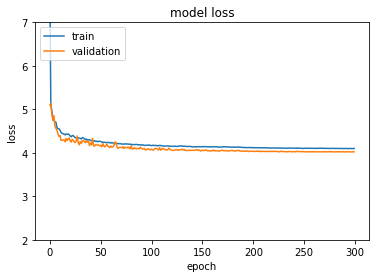

In [31]:
# Training history
# 2019-05-10

"""
[INFO    ] Done training. Time elapsed: 2:22:29.824547 sec
[INFO    ] Epoch 300/300 - loss: 4.10035100212 - regr_loss: 3.65443139831 - discr_loss: 0.0148639867912 - val_loss: 4.02185552826 - val_regr_loss: 3.58684881668 - val_discr_loss: 0.014500223606
"""

from IPython.display import Image
Image(format="png", data="iVBORw0KGgoAAAANSUhEUgAAAXwAAAEWCAYAAABliCz2AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzt3XmcXFWd9/HPr5bu6n1LZ18hLCEhZGUREokRBAEFWZ8RZ8Al44qMOjOoMyMzjz4yoyLD6IA4AyIqy0QRHVEETNiXLIYQSAJJSEhn7XSn9+7q6qrz/HFud0LoLUv1UvV9v1796qq6t+49t27395577rmnzDmHiIhkvtBgF0BERAaGAl9EJEso8EVEsoQCX0QkSyjwRUSyhAJfRCRLKPBFADP7iZl9s5/zbjWz9x/tckQGmgJfRCRLKPBFRLKEAl+GjaAp5W/N7FUzazKzu81slJn93swazOwJMys7aP4PmdlrZlZnZsvNbNpB02ab2WozazSzB4HYIeu62MzWBO993sxmHmGZP2Vmm8ys1sx+Y2Zjg9fNzL5vZnuDsr9qZjOCaR80s9eDsu0ws68c1QcnElDgy3BzOfB+4CTgYuAPwNeAkcHf8w340DwRuB+4EagEHgV+a2Y5ZpYD/Bq4DygH/idYLsF7ZwN3A38NVAA/An5jZrmHU1Azex/wbeAqYAywDXggmHw+sBA4ESgJ5qkJpv038NfOuSJgBvCnY/kBSvZS4Mtw8x/OuT3OuR3AM8CLzrk/O+fagIeB2cF8VwO/c8497pxLAN8F8oD3AGcCUeA251zCObcUWHHQOpYAP3LOveScSzrn7gXiwfsOx0eBu51zq51zceCrwFlmNhlIAEXAyYA559Y753YF70sAp5hZsXNuv3Nu9TH67CTLKfBluNlz0OPWbp4XBo/HBjVqAJxzKWA7MC6YtsO9c+TAbQc9ngR8OWjOqTOzOmBC8L7DcWgZmoJa/Djn3J+AHwA/BPaa2V1mVhzMejnwQWCbmT1lZmcd5npFuqXAl0y1MwhuCNrMg9DeAewCxgWvdZp40OPtwLecc6UH/eQ75+4/yjIUBE1EO/AHgNudc3OBU4Kmnb8NXl/hnPtw0Ez1a+Cho/gcRLoo8CVTPQRcZGaLzSwKfDlolnkeeAHoAG4ws6iZfQQ4/aD3/hj4tJmdEVxcLTCzi8ys6DDLcD9wvZnNCtr//x/wknNuq5nND5YfBZqBNiAVXGP4qJmVBE1RDUDqGH82kqUU+JKRnHMbgWuB/wD2AZcAlzjn2p1z7cBHgOuA2qC9/1cHvXcl8KmgyWU/sCmY93DL8ATwj8Avg7OK44FrgsnFwYFlf9DsUwN8J5j2MWCrmTUAnw6uBYgcNdMXoIiIZAfV8EVEskTaAt/MTgpuXOn8aTCzG9O1PhER6d2ANOmYWTjomXCGc25bP94iIiLH2EA16SwGNivsRUQGT2SA1nNN0EXtXcxsSXBnIwUFBXNPPvnkw174jrpWGloTTBtT3I+5RUQyx6pVq/Y55yr7M2/am3SCcUt2AtOdc3t6m3fevHlu5cqVh72Orz/8Ko+9tpuV/3De0RRVRGTYMbNVzrl5/Zl3IJp0LgRW9xX2RyNkRkq9S0VEejUQgf9/emrOOVZCBindTyAi0qu0Bn4wdsh5B9/FmKb1kFIVX0SkV2m9aOucaw4GizpiiUSCqqoq2traepznA+OSLKisZP369UezqqwQi8UYP3480Wh0sIsiIgNsoHrpHLGqqiqKioqYPHky7xzc8ICdda3UNrczbVzJgJdvOHHOUVNTQ1VVFVOmTBns4ojIABvyQyu0tbVRUVHRY9gD9DJJDmJmVFRU9Hq2JCKZa8gHPkFQybGhz1Ikew2LwO8PXbIVEeldRgS+kb7Er6ur4z//8z8P+30f/OAHqaurS0uZRESOREYEvo/89CR+T4Hf0dHR6/seffRRSktL01ImEZEjMeR76fSLpa9J56abbmLz5s3MmjWLaDRKLBajrKyMDRs28MYbb3DppZeyfft22tra+OIXv8iSJUsAmDx5MitXrqSpqYkLL7yQc845h+eff55x48bxyCOPkJeXl6YSi4h0b1gF/j//9jVe39nwrtcTyRTtHSkKcg9/c04ZW8w3Lpne4/RbbrmFdevWsWbNGpYvX85FF13EunXruro13n333ZSXl9Pa2sr8+fO5/PLLqah4560Hb775Jvfffz8//vGPueqqq/jlL3/Jtddee9hlFRE5GsMq8IeC008//R192G+//XYefvhhALZv386bb775rsCfMmUKs2bNAmDu3Lls3bp1gEstIjLMAr+nmvjehjZ2N7QxY1wJoTR3OywoKOh6vHz5cp544gleeOEF8vPzOffcc7vt456bm9v1OBwO09ramtYyioh0J0Mu2qZPUVERjY2N3U6rr6+nrKyM/Px8NmzYwIsvvjjg5RMR6a9hVcPvUWel3h30+BipqKjg7LPPZsaMGeTl5TFq1KiuaRdccAF33nkn06ZN46STTuLMM888tisXETmGBuQ7bfuruy9AWb9+PdOmTev1fdWNbeyqb2P62BLCId1J2pf+fKYiMjwMtS9AGQAHV/FFRKQ7GRL4nuJeRKRnGRH4pgq+iEifMiLwRUSkbxkR+Krgi4j0LSMCX0RE+qbAP8YKCwsB2LlzJ1dccUW385x77rkc2v30ULfddhstLS1dzzXcsogcrYwI/M6LtkPolgLGjh3L0qVLj/j9hwa+hlsWkaOVEYF/zG+vPchNN93ED3/4w67nN998M9/85jdZvHgxc+bM4dRTT+WRRx551/u2bt3KjBkzAGhtbeWaa65h2rRpXHbZZe8YS+czn/kM8+bNY/r06XzjG9+AYEC2nTt3smjRIhYtWgTBcMv79u0D4NZbb2XGjBnMmDGD2267rWt906ZN41Of+hTTp0/n/PPP15g9IvIOw2tohd/fBLtffdfLRakUxyVSRHLCh/+N5qNPhQtv6XHy1VdfzY033sjnPvc5AB566CEee+wxbrjhBoqLi9m3bx9nnnkmH/rQh3r8vtg77riD/Px81q9fz9q1a5kzZ07XtG9961uUl5eTTCZZvHgxa9eu5YYbbuDWW29l2bJljBgx4h3LWrVqFffccw8vvfQSzjnOOOMM3vve91JWVqZhmEWkVxlSw0+f2bNns3fvXnbu3Mkrr7xCWVkZo0eP5mtf+xozZ87k/e9/Pzt27GDPnj09LuPpp5/uCt6ZM2cyc+bMrmkPPfQQc+bMYfbs2bz22mu8/vrrvZbn2Wef5bLLLqOgoIDCwkI+8pGP8Mwzz4CGYRaRPgyvGn4PNfGmlna217Zw0qgicqPhY77aK6+8kqVLl7J7926uvvpqfv7zn1NdXc2qVauIRqNMnjy522GR+/LWW2/x3e9+lxUrVlBWVsZ11113RMvppGGYRaQ3GVHDT/dwaVdffTUPPPAAS5cu5corr6S+vp6RI0cSjUZZtmwZ27Zt6/X9Cxcu5Be/+AUA69atY+3atQA0NDRQUFBASUkJe/bs4fe//33Xe3oalnnBggX8+te/pqWlhebmZh5++GEWLFhwzLdZRDLP8Krh9yFdnXSmT59OY2Mj48aNY8yYMXz0ox/lkksu4dRTT2XevHmcfPLJvb7/M5/5DNdffz3Tpk1j2rRpzJ07F4DTTjuN2bNnc/LJJzNhwgTOPvvsrvcsWbKECy64gLFjx7Js2bKu1+fMmcN1113H6aefDsAnP/lJZs+ereYbEelTRgyPXNfSztu1LZw4qohYGpp0Mo2GRxbJHFk3PLJGwBcR6VtGBD5D8MYrEZGhZlgEft/NTho+rb+GUhOeiAysIR/4sViMmpqaXoNKcd8/zjlqamqIxWKDXRQRGQRDvpfO+PHjqaqqorq6usd52hJJ9jW14/bnkhMZ8sewQRWLxRg/fvxgF0NEBsGQD/xoNMqUKVN6nWfZxr186hcrePiz72HaxLIBK5uIyHCSEdXhUDCGTUptOiIiPUpr4JtZqZktNbMNZrbezM5Kx3pCXb10lPgiIj1Jd5POvwN/cM5dYWY5QH46VqIavohI39IW+GZWAiwErsPXvtuB9vSsy/9OqYYvItKjdDbpTAGqgXvM7M9m9l9mVnDoTGa2xMxWmtnK3nri9OZADV+BLyLSk3QGfgSYA9zhnJsNNAM3HTqTc+4u59w859y8ysrKI1pRZ+Ar70VEepbOwK8CqpxzLwXPlwYHgGMupCYdEZE+pS3wnXO7ge1mdlLw0mKg969zOkKmi7YiIn1Kdy+dLwA/D3robAGuT8dKVMMXEelbWgPfObcG6Nc4zUfjQBu+Al9EpCeZdadtarBLIiIydGVE4KsfvohI3zIi8HWnrYhI3zIj8IOtUBu+iEjPMiPwVcMXEelThgS+/602fBGRnmVE4JvG0hER6VNGBL4GTxMR6VuGBL7/rX74IiI9y5DAVw1fRKQvmRH4IQ2PLCLSl8wIfPXSERHpU4YEvvrhi4j0JSMCX2PpiIj0LSMCX8Mji4j0LaMCX006IiI9y5DA97/VpCMi0rOMCHx9p62ISN8yIvA7a/hqwxcR6VmGBL7utBUR6UuGBf5gl0REZOjKiMBXP3wRkb5lROAf6Ic/2CURERm6MiTw/e+U2nRERHqUIYGvNnwRkb5kROB3tuEn1aYjItKjDAl8w0z98EVEepMRgU/QrKNeOiIiPcuYwA+bqQ1fRKQXGRP4ZuqHLyLSm4wJ/JglcKrii4j0KDMCv76KV8If46wdPxnskoiIDFnDP/A72uGhvwLghLpnBrs0IiJD1vAP/GQciscA0JKKDHZpRESGrLQGvpltNbNXzWyNma1My0pyi+Cq+3i5cBH58eq0rEJEJBMMRJV4kXNuX1rXYEaoaAzljc8TT3SQG1VNX0TkUMO/SSeQVzGefIuzdcfuwS6KiMiQlO7Ad8ATZrbKzJZ0N4OZLTGzlWa2srr6yJtkSkdNAKBq+5YjL62ISAZLd+Cf45ybBVwIfM7MFh46g3PuLufcPOfcvMrKyiNeUeXYyQDU7Np2dCUWEclQaQ1859yO4Pde4GHg9HStK6d0HAAtNVXpWoWIyLCWtsA3swIzK+p8DJwPrEvX+igcBUCqQW34IiLdSWd3llHAw+YHq48Av3DO/SFta8stpC1cSG7LLpxzWOcg+SIiAukMfOfcFuC0dC2/O80FExi3fzfVtfsZWVoMYXXPFBHplDHdMgGSZcczxXZReN8H4E//MtjFEREZUjIq8HNHncgEqya/7g3Yu36wiyMiMqRkVOAXjj2JkPkhkl2jLt6KiBwsowI/XHlC1+PW2p2DWhYRkaEmowKf8uO7Hua210IqOajFEREZSjIr8PNKoXQS8UghYVJUVb092CUSERkyMivwAT75BPWLbgHgzt89x/Ob0ztQp4jIcJF5gV84kpGTpgGwY/tWfvCnTYNdIhGRISHzAp8DwyxcNNl4bWcDzunLzUVEMjrwT8hvpr41wY661sEukYjIoOtX4JvZF82s2Lz/NrPVZnZ++ot3hCI5kFfOuPB+ANbtaBjsEomIDLr+1vA/7pxrCEa8LAM+BtyS5rIdnXFzqNixjNxQktd31g92aUREBl1/A79z6MkPAvc551476LWhaf6nsKZdfLziNe5fsZ0t1U2DXSIRkUHV38BfZWZ/DAL/sWCc+1Say3Z0TjgPyo/jb0IPEk40877vPcXfL12rC7gikrX6G/ifAG4C5jvnWoAocH2ay3Z0QmH40H+QU7+Vx2c/x1+eNYkHV27njqc2D3bJREQGRX8D/yxgo3OuzsyuBf4BGPoN45PPgRM/QNG2x/nnD03nvFNGcceyzTTFOwa7ZCIiA66/gX8H0GJmpwFfBjYDP01z2Y6NyedA7RascTefPfd4GuMd/M/K7YNdKhGRAdffwO9wvvH7w8APnHM/BIrSXLZjY9LZ/ve255g9sYz5k8u45fcbeHDF2yRTas8XkezR3+8AbDSzrwbdMReYWShoxx/6Rs+EnCJ462k49QruvHYun/nZav7+l69y+5ObuO49k0k6x2s7GyjJixAJhfjsouMZWRQb7JKLiBxT1p9eK2Y2GvgLYIVz7hkzmwic65w7ps068+bNcytXrjyWi/SWfgLe/CMsWQ55ZaRiZfzx9T389IWtPL+5BoDiWIRE0tGRSlFekMOjNyygvCCHPQ1x8nPDFMeGx/FNRLKLma1yzs3r17z97aZoZqOA+cHTl51ze4+mkN1JW+DvWA0/XuQfH78YPvYr8F+0zu9e3UVLPMkVc8fjgNd3NnD5Hc9zxnHllORF+d+1uyjKjfDQp89i2phi2L4C1vwMLvo+hDJzZAoRGT4OJ/D7O7TCVcDLwJXAVcBLZnbFUZd0oIybA9Mv8483PwkpfwuBmXHxzLFcNX8CoZARDhmnji/h/146nec27eN/1+7iE+dMIT83zHX3vMxrO+th9b2w6ifQuKtr8c45dtW3qo+/iAxp/W3SeQU4r7NWb2aVwBPOudOOZWHSVsPv9OefwSOfg8+vhBEHvg6Rhl3Q3gwVx/t52upZPf6jvF3TwqWzx7FhdwPX3b2C6qY4f8r/KpM6tvLp0M2Ep76X86aNYtPeJn6wbBMnjy7i+1fP8mcCPdnzOoycBja0b1QWkeHhcGr4/b1oGzqkCadmWI60OXa2/71j9TsD/5HPwq61cNo18MIPAJjzlauYUxqCTU9y8tTF/OYLZ3Pf8nVMWLUNgPeNbOS7b9Xyu7W+pr/ghBG8uaeJy+94ns8tmsrmvU3csPgEJpbns6OulQnl+bDrFfjRQrj2VzB18SB8ACKSzfob+H8ws8eA+4PnVwOPprFc6THiJIjmw5/vg+0vwt4NUHmi78GT6vBhP+Y0H8yvPwKb/wQbH4UPfJuRZ32WL09vglX+jOiqKXGu/OvF/O/aXTz75j7+6f1jiO/ewPVP5PKdxzYSIsXv1+0mPydMTXM7SxYex4WJp5kNsHc9HVMWEQkPv2OmiAxf/Qp859zfmtnlQNCpnbuccw+nt2hpEI7AhDNgyzLYvRYKKuHt5/20wlHQ0eZr3z+5GFbeA/s2QqwUHvuaPzvYvMyPGVc8Dmo2Y6kkl0yIc0lxHfzH+ylIxll60e28PqOQGS98iQdHf4Vo+36W51/AXU9voTzyIrMj8NizL/CF3x3PR+aMoygW4ZwTKqlujLOvKc4JIws5e+oIYtHwYH9aIpJh+t1LZyCkvQ0ffFt9WwMUjYZEC9w+29fuP/2cnzZi6oG2foBPPAG//AQ4B637fVOMS0L1Rpj3cX8wGHEitNVDxVTY/jKUjIPaLV2rTF31M9YUnsPUxz9B8fYneclO4/Zx/8Zzm2ow84s+WElelEtnjWVUSYy8aJjyghxOGVOMmbF9fwtjS/I4cVQhexvjREJGRWEuPPt9aN4HC74M+eXp/QxFZMg4Zm34ZtYIdHdEMF/xd71cnRyicgr8T+fja34B8UYoHnNgntnXQrId9r0JE+bDlT+BX1wF7U1w7k3wygOw8Q+w9iFwKajeAAv/Ds74NNxzAex7A+Z/Cna/CttfJPTWcuYUvwG1awE4o6SOn3/yTKob48SiIZ5cv5epIwuZVJHP6rfrWLqqisdeXsfeZAGpHi6VHDeigLdrWzCDj8yo4F833gxAw65NvLnoDkryoowsjhE2oyC3vy13IpLJsq+Gf6Qa98D+t2Dimb7N/95L/Ovlx0N9FXx+BZRN8j1+Xv81zPuE/+at/zoPqlYcOG6GcyGVgK/vgdZa6IhD6cR39tpprcN9fzodZ3yexjO/THVjnJqXH6Cp/FTKxp/Ixt2N/GbNTiaPyCc/J8Kulb/lR6FvU+VGUEwzs+I/7jpQ5IRDnDK2mPKCHCIho6EtQXVjnGTKMb4sn4rCHIpjUdo7Ulw2ZxyxaJjC3AhN8Q7aO1LUNseZM7GMkcUxUilHKKTeRSJDSTp66UjRKP8DMGUhTD0PNj3ua/8l4w80oxSPgTM/c+B9E8+EqpcPPJ9wOmx9xt+89buv+OahqeeBheDED0DxWGjcjbU3EV3935S/90uUb1sGq78C40+Hs//I/MnlXHvmpK5FJkL3kFoTIz73byh+6es8cGkJG5lEU1sH+5ribNjdwJ6GNpIpR3EsygkjiwiHjF31rWza0kR9awIzeLCXQeUqCnKobWmnoiCXkUW5RMJGLBrm/FNGUZgbYV9TnOrGOPtbEhTnRZg3qZzKolzWVtUzviyPSMhoaU8ya2Ipk8rzqW1u58W3ainMDTN3Yjkl+bqTWSTdVMM/UvU74I0/+Hb83vrUb/wD3H81XHSrv1lr4lnws49AOMeH+8xr4NlbIVYCzdX+PRbyP6kOOOdLsOoeSCUh3uAPMKdcCs98z3ctHX863Hk2jJ8PF9wCt8+Ci74H8z/57rI4121ZnXM0vXA3qRV3s3LxQzQmoCgWIWRGSX6Ul9+qZfPeJkYW57KvsZ3qpnhws1kbG3Y3di2nKBahvCCH2uZ2Gtv6PwR1OGRUFuYysTyfkvwozsHexjY6ko6iWITivChFsQjHVxYyqjhGXUs722tbKIpFOXF0EbVNcWqb2/nz9jrW72qkJC/CghMqKY5FCIdCmMGkinxK8qI0tnUQi4bJzwkzqjiXqSPfPQZgRzJFXWuC/JwwedEwHSlHvCNFPJEk3pEimXKUF+S8q6ks3pEkNxLuugHP+rjXoiOZwszf8CdypNIytMJAGFaB31+pFLy1HI5bRNcV2qf+DV59CC6+DaYs8GGO+fk2Pem7h876KNRv981HsRL4+B/hwWuh5k1/0Hj7BX9QKJngDxRLlvuLx987yZ9FXHwb7Frjr08UjoLnbvcXnT90O+xZB1POhbUPwI5V8OEfwn+9379+3aMw6T3+ekXuIWFYXwVr7of3fB6ieTjn2FnfBsEZQGfPomTKsWF3AzVN7Zwytpjd9W2EQ0Y0bLywpZbapnaKYhHmjTJaQwU8t2U/O+ta2bqvmeb2JAAjCnPIjYRoaO2goS1BQ2uia10ABTlh2oLwBQgZTB5RwPxJ5WytaWbdjvquZfWmoiCH/S3t5ERC5IRDXeHen5FU86JhImEDB0nnaGlPMrIol7qWBIlUimjYL3NcaR5TRxUSCRlhM7bVttCWSLKlupn2ZIqRRbmEzCiKRagsyiU3EiIa9j/xjiQ5kTAVBTnEO5I0tHYQ70hRkhelJC9Kaf6B38V5UUrzokRCIVoTSUYXx+hIpdjfkmBEYQ550TC1Le1MLM+nI+Uoyo3QmkgST6QoDc6wEklHTkTdhYcTBf5wluyA5d+GU6/01wSW3wInXgCTzvK9iJ77d3j6OzBmlm9GijfBwq/4r3QEePyf/DyxEt9z6FCRPOho7bzu7l+rmAo1m/zjsz7vL1iv/ilcdR+MPNkfdMbOht/e6Junzvo8nP9NSCZ899Zxcw+cOSQ7fPfXQ7W3wKYnoHSCL3tLje8hdc6NvmfR5mW+HKUT3vm+F+/0r518ETVNcZrjSUryoxTHItQ2t1PT3E5FQQ6l+TnvqimnUo6Uc3SkHG/XttDQmqAkL0pbIkVLewcb9zSyZntdEIyO9o4UkZBvqqosyqU1kaQl3kE0HCI36sM7NxomHDJqm9upboyTcp0HHKM4FmVrTTOVRbnEomESyRRtiSRv17SwqboJ5/zBcGxpjMLcCOPL8inOi7C7Po7Dsb+5nf0tCRLJFIlkivYOf9BoTSRpaE346yuxCLmRMA2tCepa2vt1UOtJyKDzuFaUG6GtI0ki6cjPCRMyI+X859e53bFoiNxImNxIiNxIiGTKkUg6ioNRZjvLHTIjEraug1Yk5B/nRELEguU4B63tSf8Ztyf9MoPXY1E/X140zP4Wf7AfUZhDe9K940AXDYeoaYrT0JYgEgoRDRtmhpnfH6HgdzhkREJGXk6EhtYExXlR6lsT7G9uh+AMMxo2ygtySaZS5ERCNLZ1UJrvKx0E/ynOOZyDfU1xJpTnEwkZ8Y4UOeEQoZCvy6UcXX9DsWiIRNJR29xOQW6YcaV5pJxjX1M7iWSKsvwcksHfaGNbBwtPrDyi/ajAz3TVG6FwJOSVvXtaog3uPt/X7C+61dfud62BaB48/T1/hnDpHX4ZOQW+aekPf+/fO+Y03zMp0QK5JRCvBwv76wydRs/0IZ9bDHmlUPc2XPx9GHkK/Omb8PaLcNF3fVPT09+Bs2/w6/jppdAc3Kx9/Pv8TXAv3eHvaTjtGt9ElVPoDyTFY334V2+AB/4CQhG48l6YdvG7tzfeBOEoRHL9mVJbPWz8vd/+4871Zz9TFvT/s23e52/Oy8k/7N0yGBLJFPWtCepaEtS3JqhvbSeRdMSiYfY2tBEJG6V5OexritPSnqQ0P0rV/lZywiHqWxMUxiJEQsb22hbyciLk54Spb01AcEAwM9o7UsQ7/JlAvMMfxOIdqa6grGtJkHKuK+BTztGRdCRS/gDQkXT+AJZM0ZZI0daexAzycsLk50SIRcNdzWWhEF3ztCaS5OWEKcv3Z2GdZ3ztyXd+nXY4ZEf03Rad9YOh8LUY5QU5rP7H847ovQr8bNcR98094UMuhDbu9jXrUdPf+frONb65JqcAnv4ujD4V3vt38Mr90LDTXzPY/5YP4nHz4JVf+LuR923yTT+71/ruqcXj/DxVKw4sO1biyxKJ+aaj6o3+wJBo9je1tdX5+U77C2io8mcT4A8SLgWV0/zJyO5XYfICmHmVP7N47WF/sGnY6Q98Fcf7Zq7uLPo6VJ7sb7Sr2eSbygpH+YNBKOLXFc6Bbc/C+t/6s6AFX4Lat/zZk0v5u7MnnOHPfpb/q7/X4rx/eednmUpB/dvwxM1+e6Yu9mdluUUHzoCaqv01GQvBCef7z7pqpe8QUDrxwLIadvrPMVYCkxceGJl1z2t+P+L8QXnCfDKZc+4d10Kcc7QmktS3JmjvSDGiMJeC3AjO+bMNhwtq2o5UcEblnKM9maIlnqQ4L9p1pleSFyUUsq7pNU3tRMJGIukozIlQ29IeXGfpXLs/eyjNi7JpbxORcIiC3DDtHSlSLjhAYnSkUl1NZdFwiLKCqD8bDZZfHIsSCRuNbR2Eg4VPKM/npNFH9p1SQyrwzSwMrAR2OOfDPoswAAAMgklEQVS6qaIdoMAfhuq2+2ak8fNgzl/5AF11jz9LmHSOb57KKYDF/wSVJ/n31G7xTVVzr/fTJ58DC//WnxNv+K1fxqYnfS37PTf4s4mXf+RHKe28oW3Eib5pqGgUvPFH38V1zl9C/gjfDFW33Yfjvjf8ndX9Ec7xzVVbnz3QsyqcE5yrJw7MN+Ikfz2krd4fDFwSKk6A/VshGffzWNhvRzIOeeUwdpbv2rv39WAhwf9dKOqXHYn5g2lzNTTtOXAg9AvzB7Rovj+4HuyUD/v1upS/cJ9b7J+HIv5gc+oV/iDX1gAFFVCzBSae4Q9+ddt9R4KOuP+cZlzuP/Nwrj8TLBoDpZOgYYff1uJx/sCz7XkYNcOvI6/UD0GSVw7lx/kDVOfnESuBtQ/6s6YJ8/3nlmz3Z3I5+X6b973p11Uw0o9qm2z3lZKcQr/O2s1+PgtDwQhfiSkY6T+flhp/IA+FoaPd/83llfrtSbT4CkUq6T/TotFHNmBh50HcQn77LdT9cpzz+6BzeiK43hTt44uUnPM/RzHU+lAL/C8B84BiBb4cFed84FnY16wPvm7gkr5Z51CpFNRt9eHRUgPF4/21keZ9/mzEpXzIJNt9uOcU+OsNbz3lDyor7/bLOX2JD9Lmajj5Ih/4T3/HB5OF/MGlYirkV8BJF8Dq+4JwqvSBtnONb4abcKYfqju/wh/cajb73lZbn/VnLAWVfr7y4/3F99q3oHq9v4M70Qozr/bzp5L+rGPzMhg/1382VSt90JVO9KGXjPttxvxn09HmDwjxhgOfj4X951gwEhp3Htl+sZD/HI/2fRY0hHd7r2cPInmQW+j3J84fFBMtflo41y8/lfDfeheO+L8HlwwOyKEDB2bwlQaX8s8tfOC9qY4D63JJv9xwxO+DZDC9s0KQU+h/mqt9eUon+QNvS40vm4WCg16B39eNO/3f26hTYMlTR3RQGjKBb2bjgXuBbwFfUuCLHGMHd7VNJX3Qd15/aKv3B6LRM30tua3O18Rrt/hpJeP9waWzdrpjpb/Wk2jztfXmvbB/m2++ipX6ZqaONn+tZ/erPrSa9gSj0Bo07T7QUWDnGj/vlIX+TGzjo379kZgPwM6f4jEwdo4vU/VGH7ZFo/28FvZnRsmED8nW/X77WvZBtMCfQexZ56/XFI3x2924229jNM+XzUJ+WmenhFDkwIHGJYOwTvrn+eUHrlmlkv5zDUWgbLLfvuoNwVlbu58ejvqzi1DUvx6K+DImmn2ToYX8NkVi/jNMtPr3RXL8fK11fr7cQr9dF/7rEf0JDKXAXwp8O/jC8690F/hmtgRYAjBx4sS527ZtS1t5REQyzTH/xqsjLMTFwF7n3Kre5nPO3eWcm+ecm1dZeWTdkkREpG/pvMPibOBDZrYVeAB4n5n9LI3rExGRXqQt8J1zX3XOjXfOTQauAf7knLs2XesTEZHe6R5qEZEsMSCjZTrnlgPLB2JdIiLSPdXwRUSyhAJfRCRLKPBFRLKEAl9EJEso8EVEsoQCX0QkSyjwRUSyhAJfRCRLKPBFRLKEAl9EJEso8EVEsoQCX0QkSyjwRUSyhAJfRCRLKPBFRLKEAl9EJEso8EVEsoQCX0QkSyjwRUSyhAJfRCRLKPBFRLKEAl9EJEso8EVEsoQCX0QkSyjwRUSyhAJfRCRLKPBFRLKEAl9EJEso8EVEsoQCX0QkSyjwRUSyhAJfRCRLKPBFRLKEAl9EJEukLfDNLGZmL5vZK2a23sxuSde6RESkb5E0LjsOvM8512RmUeBZM1vgnHsmjesUEZEepC3wnXMOaAqeRoEwsD9d6xMRkd6ltQ3fzMJmtgbYCyx3zq3rZp4lZrbSzFZWV1enszgiIlktrYHvnEs652YB44EFZraom3nucs7Nc87Nq6ysTGdxRESy2oD00nHO1QG/A+YNxPpEROTd0tlLp9LMSoPHecB5wJp0rU9ERHqXzl46Y4B7zSwUHFh+5px7PI3rExGRXqSzl85aYHa6li8iIodHd9qKiGQJBb6ISJZQ4IuIZAkFvohIllDgi4hkCQW+iEiWUOCLiGQJBb6ISJZQ4IuIZAkFvohIllDgi4hkCQW+iEiWUOCLiGQJBb6ISJZQ4IuIZAkFvohIllDgi4hkCQW+iEiWUOCLiGQJBb6ISJZQ4IuIZAkFvohIllDgi4hkCQW+iEiWUOCLiGQJBb6ISJZQ4IuIZAkFvohIllDgi4hkCQW+iEiWUOCLiGQJBb6ISJZQ4IuIZAkFvohIllDgi4hkibQFvplNMLNlZva6mb1mZl9M17pERKRvkTQuuwP4snNutZkVAavM7HHn3OtpXKeIiPQgbTV859wu59zq4HEjsB4Yl671iYhI79JZw+9iZpOB2cBL3UxbAiwJnjaZ2cYjXM0IYN/RlXTI0LYMPZmyHWhbhqwj3ZZJ/Z3RnHNHsPz+M7NC4CngW865X6VxPSudc/PStfyBpG0ZejJlO9C2DFkDsS1p7aVjZlHgl8DP0xn2IiLSt3T20jHgv4H1zrlb07UeERHpn3TW8M8GPga8z8zWBD8fTOP67krjsgeatmXoyZTtQNsyZKV9W9Lehi8iIkOD7rQVEckSCnwRkSwx7APfzC4ws41mtsnMbhrs8hwuM9tqZq8G1zhWBq+Vm9njZvZm8LtssMvZHTO728z2mtm6g17rsexm9tVgP200sw8MWsG70cO23GxmO7q7BjXEt6XbYU2G277pZTuG3X4xs5iZvWxmr5jZejO7hcHYJ865YfsDhIHNwHFADvAKcMpgl+swt2ErMOKQ1/4NuCl4fBPwr4Ndzh7KvhCYA6zrq+zAKcH+yQWmBPstPNjb0Me23Ax8pZt5h/q2jAHmBI+LgDeCMg+rfdPLdgy7/QIYUBg8jgY3oS4Y6H0y3Gv4pwObnHNbnHPtwAPAhwe7UMfAh4F7g8f3ApcOcnm65Zx7Gqg95OWeyv5h4AHnXNw59xawKdh/Q0IP29KTob4tPQ1rMqz2zREMzzIktwNffuecawqeRoPK6v6B3ifDPfDHAdsPel41DMfrccATZrYqGGYCYJRzblfweDcwahDLd7h6Kvtw3VdfMLO1QZNP5+n2sNmWQ4Y1Gbb7ppvhWYbdfjGzsJmtAfYCy51z6wZ6nwz3wM8E5zjnZgEXAp8zs4UHT3T+/G5Y9p0dzmUP3BE0F84CdgHfG+wCHY5gWJNfAjc65xoOnjac9k032zEs94tzLhn8r48HFpjZokOmp32fDPfA3wFMOOj5+OC1YcM5tyP4vRd4ODht22NmY/B/7GOCGsFw0VPZh92+cs7tCf5JU8CPDzqlHvLb0sOwJsNu33S3HcN5v+DLXwf8Dpg30PtkuAf+CuAEM5tiZjnANcBvBrtQ/WVmBcF3BWBmBcD5wLpgG/4qmO2vgEcGt6SHpaey/wa4xsxyzWwKcALw8iCWs0+d/4iBy4J9w1Dfll6GNRlW+6an7RiO+8XMKs2sNHicB5wHrBnwfTLYV6+PwdXvDwZX7zcDXx/s8hxm2Y8LrsS/ArzWWX6gAngSeBN4Aigf7LL2UP77g1PqRNDG+Ineyg58PdhPG4ELB7v8/diW+4BXgbXBP+CYYbIt5wRNA2uDUFkT/J8Mq33Ty3YMu/0CzAT+HPyvvwr8vevjfz0d26KhFUREssRwb9IREZF+UuCLiGQJBb6ISJZQ4IuIZAkFvohIllDgixwDZnaumf3vYJdDpDcKfBGRLKHAl6xiZtcG45KvMbMfBQNaNZnZ94Mx1580s8pg3llm9mIwSNfDnYN0mdlUM3siGNt8tZkdHyy+0MyWmtkGM/t5cKeoyJChwJesYWbTgKuBs4NBrJLAR4ECYKVzbjrwFPCN4C0/De6InBncHdn5+s+BHzrnTgPeE9yhSzCa443BWObHAWcP0qaKdCsy2AUQGUCLgbnAiqDynRcMVpUCHgzm+RnwKzMrAUqdc08Fr98L/E8w9tE459zD+KFJ2vAHE4CXnXNVwfM1wGTg2cHZVJF3U+BLNjHgXufcV9/xotk/HjLfkY43Ej/ocVL/XzLUqElHssmTwBVmNpID3yc6Kfg/uCKY5y+AZ51z9cB+M1sQvP4x4Kngm5eqzOzSYBm5ZpY/aFskchhUA5Gs4Zx73cz+AfijmYWCkTE/BzQDpwfT9gbt/ATD1d4ZBPoW4Prg9Y8BPzKzfwmWceUgbpZIv2m0TMl6ZtbknCsc7HKIpJuadEREsoRq+CIiWUI1fBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSzx/wFWboA4/cEckgAAAABJRU5ErkJggg==")